# Project: Monitoring NDVI Changes and Segmenting Lost Vegetation

## 1. Introduction
**Objective**: Monitor the changes in NDVI over the years and segment areas of lost vegetation to classify what they have been converted to using the EuroSAT dataset.

**Tools**: Python, Satellite Imagery, NDVI Calculation, EuroSAT Dataset, Machine Learning Models

## 2. Data Collection and Preparation
### Step 1: Collect Satellite Images
- **Sources**: Landsat, Sentinel-2
- **Period**: Define the years for monitoring (e.g., 2000-2020)
- **Regions**: Define the geographic regions of interest

### Step 2: Preprocess Satellite Images
- **Cloud Masking**: Remove clouds and shadows
- **Radiometric Calibration**: Correct sensor noise and inconsistencies

### Step 3: Calculate NDVI
- **Formula**: NDVI = (NIR - RED) / (NIR + RED)
- **Implementation**: Use libraries like `rasterio` and `numpy`

### Step 4: Load EuroSAT Dataset
- **Download**: Obtain the EuroSAT dataset
- **Categories**: Urban, Agriculture, Forest, etc.

## 3. NDVI Analysis
### Step 1: Compute Yearly NDVI Maps
- **Mean NDVI**: Calculate average NDVI for each year
- **Seasonal NDVI**: If needed, calculate for different seasons

Table. Quote: **Holben, B.N. (1986). Characteristics of Maximum- Value Composite Images from Temporal AVHRR Data. International Journal of Remote Sensing, 7(11), 1417-1434.** 
| NDVI Range    | Class                |
|----------------|---------------------|
| <0             | water               |
| 0.03 – 0       | bare soil           |
| 0.03 – 0.3     | sparse vegetation   |
| 0.3 – 0.5      | moderate vegetation |
| >0.5           | dense vegetation    |

### Step 2: Identify Changes in NDVI
- **Trend Analysis**: Use statistical methods to identify significant changes over the years
- **Change Detection**: Highlight areas with significant NDVI reduction

## 4. Segmentation of Lost Vegetation
### Step 1: Identify Lost Vegetation Tiles
- **Thresholding**: Define NDVI thresholds to identify loss
- **Mask Creation**: Create masks for areas of NDVI reduction

### Step 2: Extract Lost Vegetation Tiles
- **Coordinate Extraction**: Get coordinates of identified tiles
- **Tile Extraction**: Extract these regions from satellite images

## 5. Classification Using EuroSAT
### Step 1: Data Preparation
- **Tile Labelling**: Label extracted tiles according to EuroSAT categories
- **Data Augmentation**: If necessary, augment data to improve model performance

### Step 2: Model Selection and Training
- **Model**: Choose a suitable classification model (e.g., CNN)
- **Training**: Train the model using EuroSAT dataset
- **Validation**: Validate model performance on a separate validation set

### Step 3: Classification of Lost Vegetation Tiles
- **Prediction**: Use the trained model to classify lost vegetation tiles
- **Post-processing**: Aggregate and interpret classification results

## 6. Results and Analysis
### Step 1: Visualization
- **NDVI Changes**: Visualize NDVI changes over the years using plots or maps
- **Classified Tiles**: Map out classified lost vegetation tiles

### Step 2: Interpretation
- **Land Use Changes**: Interpret what the lost vegetation has been converted to
- **Environmental Impact**: Discuss potential environmental impacts

## 7. Conclusion
- **Summary**: Summarize key findings
- **Future Work**: Suggest possible extensions or improvements

## 8. References and Documentation
- **References**: List of scholarly articles, datasets, and tools used
- **Documentation**: Detailed code comments and project documentation


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import IPython.display as disp
from tqdm.auto import tqdm
import pandas as pd
import os

import geemap
import rasterio
import requests
import matplotlib.pyplot as plt
import cv2
from osgeo import gdal

2024-07-04 17:50:23.782390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 17:50:24.505554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Initialize Earth Engine API

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='cementification')

In [3]:
imageCollectionInfoUrl = 'https://storage.googleapis.com/earthengine-stac/catalog/LANDSAT/LANDSAT_LE07_C02_T1_L2.json'
r = requests.get(imageCollectionInfoUrl)
imageCollInfo = r.json()
print(imageCollInfo)

{'description': 'This dataset contains atmospherically corrected\nsurface reflectance and land surface temperature derived from the data\nproduced by the Landsat 7 ETM+ sensor.\nThese images contain 4 visible and near-infrared (VNIR) bands and\n2 short-wave infrared (SWIR) bands processed to orthorectified surface\nreflectance, and one thermal infrared (TIR) band processed to orthorectified\nsurface temperature. They also contain intermediate bands used in\ncalculation of the ST products, as well as QA bands.\n\nLandsat 7 SR products are created with the Landsat Ecosystem Disturbance\nAdaptive Processing System (LEDAPS) algorithm (version 3.4.0).\nAll Collection 2 ST products are created with a single-channel algorithm\njointly created by the Rochester Institute of Technology (RIT) and\nNational Aeronautics and Space Administration (NASA)\nJet Propulsion Laboratory (JPL).\n\nStrips of collected data are packaged into overlapping \\"scenes\\" covering approximately\n170km x 183km using 

In [4]:
bands = []

for key, value in imageCollInfo.items():
    if key == 'summaries':
        for key2, value2 in value.items():
            if key2 == 'eo:bands':
                for band in value2:
                    print(f'{band["name"]}: {band}')
                    bands.append(band['name'])

SR_B1: {'center_wavelength': 0.485, 'description': 'Band 1 (blue) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '0.45-0.52 &mu;m', 'name': 'SR_B1'}
SR_B2: {'center_wavelength': 0.56, 'description': 'Band 2 (green) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '0.52-0.60 &mu;m', 'name': 'SR_B2'}
SR_B3: {'center_wavelength': 0.66, 'description': 'Band 3 (red) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '0.63-0.69 &mu;m', 'name': 'SR_B3'}
SR_B4: {'center_wavelength': 0.835, 'description': 'Band 4 (near infrared) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '0.77-0.90 &mu;m', 'name': 'SR_B4'}
SR_B5: {'center_wavelength': 1.65, 'description': 'Band 5 (shortwave infrared 1) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '1.55-1.75 &mu;m', 'name': 'SR_B5'}
SR_B7: {'center_wavelength': 2.215, 'description': 'B

In [5]:
city = 'naples'

if city == 'milan':
    geometry = ee.Geometry.Polygon(
        [[[8.967864766059032, 45.73943107755818],
          [8.967864766059032, 45.41260677458684],
          [9.434783711371532, 45.41260677458684],
          [9.434783711371532, 45.73943107755818]]])
elif city == 'naples':
    geometry = ee.Geometry.Polygon(
        [[[13.829280147955982, 41.1031243453332],
          [13.829280147955982, 40.51481111232291],
          [14.587336788580982, 40.51481111232291],
          [14.587336788580982, 41.1031243453332]]])

# Using Landsat 7 images (from 1999 to 2022, 30m resolution)

In [ ]:
# Function to compute NDVI
def compute_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI').multiply(10000).toInt16()
    return image.addBands(ndvi)

# Function to filter the collection by season and compute median NDVI
def median_ndvi_for_year(year):
    start_date = ee.Date.fromYMD(year, 3, 1)
    end_date = start_date.advance(6, 'month')
    year_collection = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
                .filterBounds(geometry) \
                .filterDate(start_date, end_date) \
                .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
                .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4']) \
                .map(compute_ndvi) \
                .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'NDVI'])

    return year_collection.median().clip(geometry).set('year', year)

# Generate a list of years
years = ee.List.sequence(1999, 2023)

year_ndvi = years.map(median_ndvi_for_year).flatten()

# Convert the list of images to an image collection
years_ndvi_collection = ee.ImageCollection(year_ndvi)

# Print the size of the seasonal NDVI collection
print(f'Adding {years_ndvi_collection.size().getInfo()} annual layers')

# Define visualization parameters for NDVI
vis_param_ndvi = {
    'min': -1, 
    'max': 1, 
    'bands': ['NDVI'],
    'palette': ['blue', 'white', 'green']}

# Create a progress bar
total_iterations = len(years.getInfo())
progress_bar = tqdm(total=total_iterations)

# Export each annual median NDVI
export = False
for year in range(1999, 2024): # From 1999 to 2023
    year_ndvi = years_ndvi_collection.filter(ee.Filter.eq('year', year)).first()
    
    # Ensure consistent band data types
    # year_ndvi = year_ndvi.toInt16()

    # print(f'info about year_ndvi: {year_ndvi.getInfo()} bands {year_ndvi.bandNames().getInfo()}')
    
    if export:
        # Export the image to Google Drive
        task = ee.batch.Export.image.toDrive(
            image=year_ndvi,
            description=f"{city}_{year}",
            folder="Environment_exam_annual_20_cloud_no_int16",
            fileNamePrefix=f"{city}_{year}",
            scale=30,
            region=geometry.getInfo()['coordinates'],
            fileFormat='GeoTIFF',
            skipEmptyTiles=True
        )
        task.start()
    
    progress_bar.update()  # Update the progress bar

# Close the progress bar
progress_bar.close()

# Create dataframe of image info

In [6]:
# Initialize an empty list to store the data
data = []

landsat_path = 'images/landsat_8_spring_summer'
for img in os.listdir(landsat_path):
    city, year = img.split('_')
    year = int(year.split('.')[0])
    # Append a dictionary with the data to the list
    data.append({'city': city, 'year': year, 'path': f'{landsat_path}/{img}'})

# Create a DataFrame from the list
img_df = pd.DataFrame(data, columns=['city', 'year', 'path', 'water', 'roads_or_urban_areas', 'vegetation'])
img_df.sort_values(by=['city', 'year'], inplace=True)
img_df.reset_index(drop=True, inplace=True)
img_df

city  year                                           path  water  \
0   milan  2013  images/landsat_8_spring_summer/milan_2013.tif    NaN   
1   milan  2014  images/landsat_8_spring_summer/milan_2014.tif    NaN   
2   milan  2015  images/landsat_8_spring_summer/milan_2015.tif    NaN   
3   milan  2016  images/landsat_8_spring_summer/milan_2016.tif    NaN   
4   milan  2017  images/landsat_8_spring_summer/milan_2017.tif    NaN   
5   milan  2018  images/landsat_8_spring_summer/milan_2018.tif    NaN   
6   milan  2019  images/landsat_8_spring_summer/milan_2019.tif    NaN   
7   milan  2020  images/landsat_8_spring_summer/milan_2020.tif    NaN   
8   milan  2021  images/landsat_8_spring_summer/milan_2021.tif    NaN   
9   milan  2022  images/landsat_8_spring_summer/milan_2022.tif    NaN   
10  milan  2023  images/landsat_8_spring_summer/milan_2023.tif    NaN   

    roads_or_urban_areas  vegetation  
0                    NaN         NaN  
1                    NaN         NaN  
2                    NaN         NaN  
3                    NaN         NaN  
4                    NaN         NaN  
5                    NaN         NaN  
6                    NaN         NaN  
7                    NaN         NaN  
8                    NaN         NaN  
9                    NaN         NaN  
10                   NaN         NaN

## Plot images

/home/andrea/unimib/.venv3-12-1/lib/python3.12/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


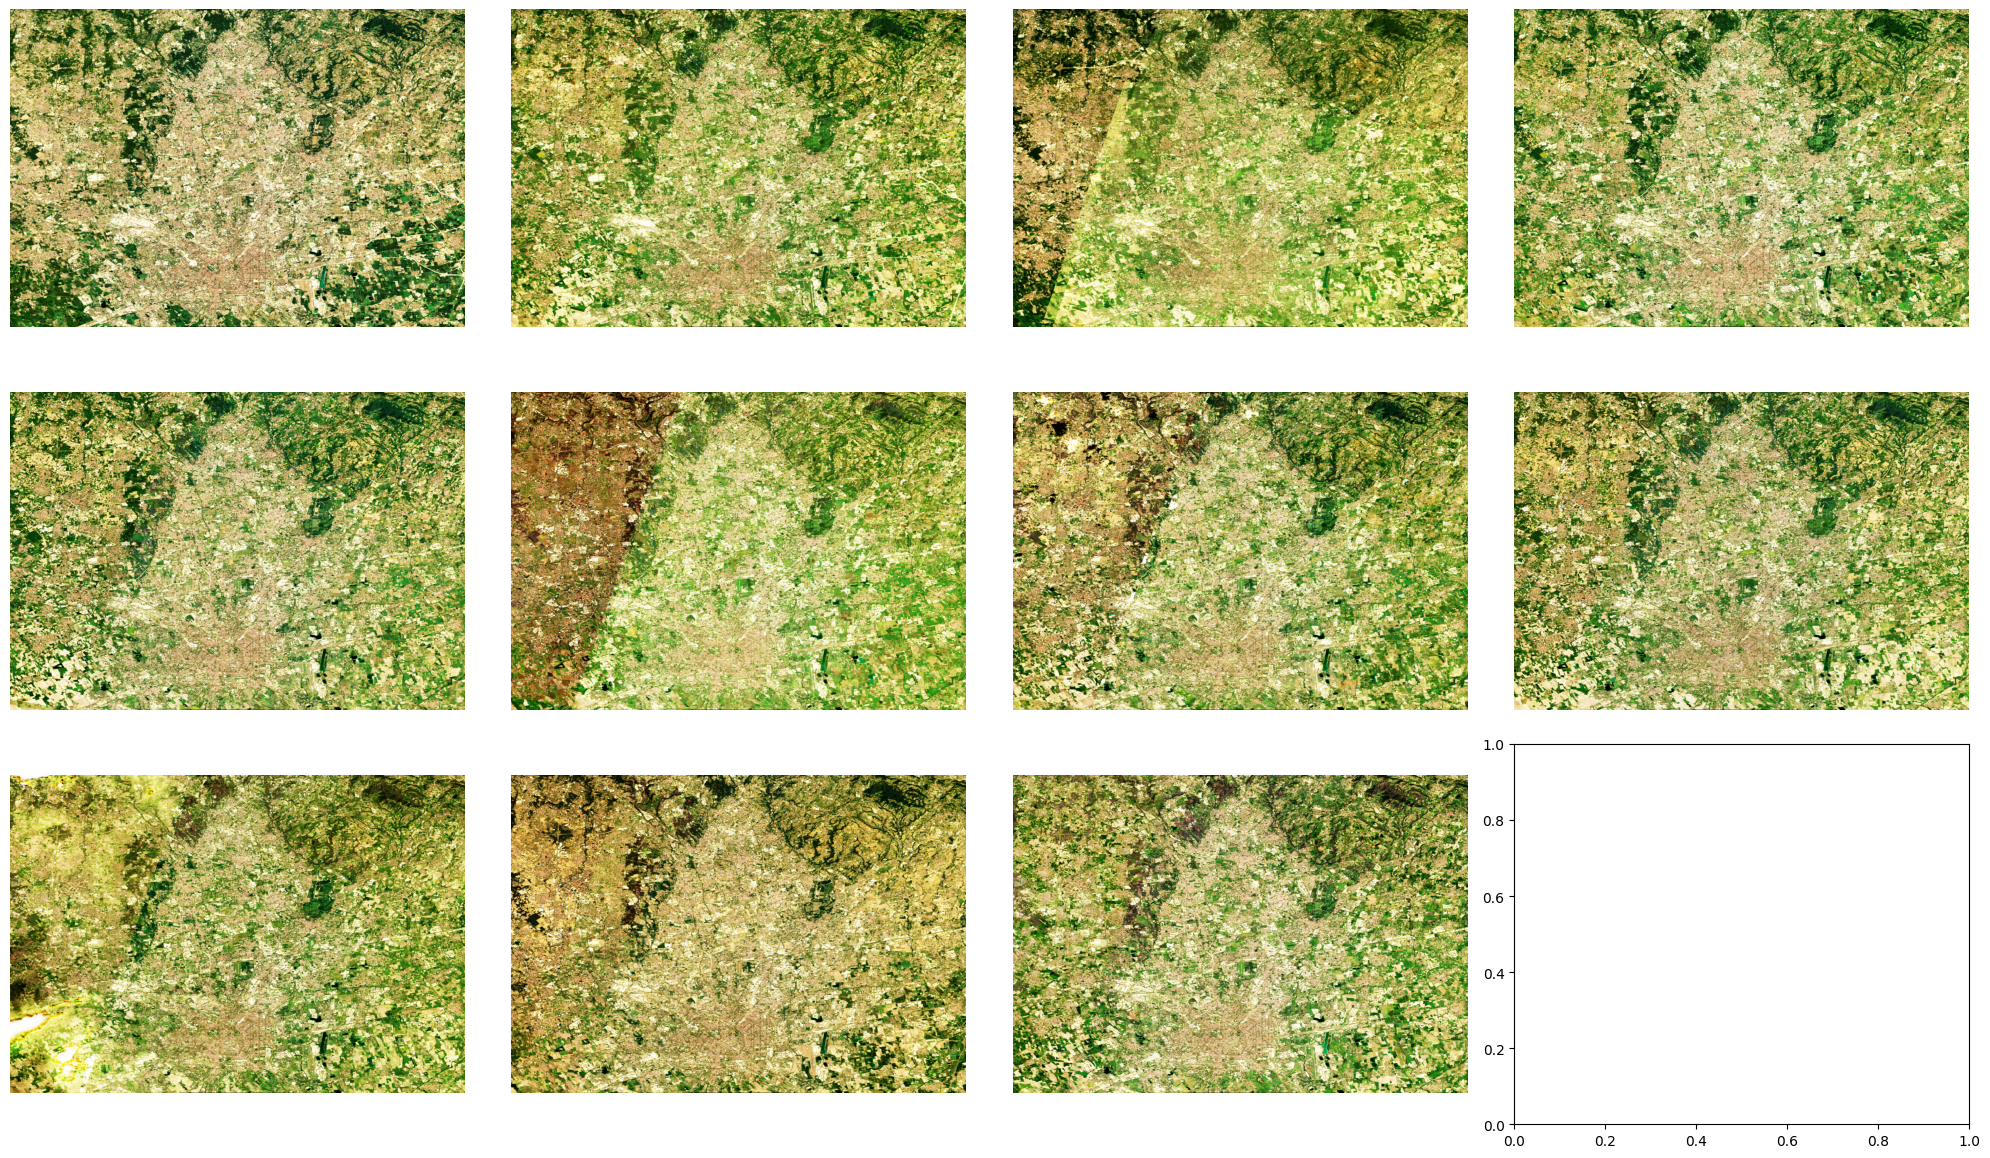

In [7]:
import matplotlib.pyplot as plt
from skimage import exposure

# Define the number of rows and columns in the grid
num_rows = 3
num_cols = 4

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Iterate over the images and plot them in the grid
for i, img_path in enumerate(img_df[img_df['city'] == 'milan']['path']):
    # Read the image using rasterio
    with rasterio.open(img_path) as src:
        red = src.read(4)
        green = src.read(3)
        blue = src.read(2)
        red = np.nan_to_num(red)
        green = np.nan_to_num(green)
        blue = np.nan_to_num(blue)
        img = np.stack([red, green, blue], axis=-1)
        img = exposure.equalize_hist(img)
    
    # Plot the image on the corresponding axis
    axes[i].imshow(img)
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Plot NDVI Histograms

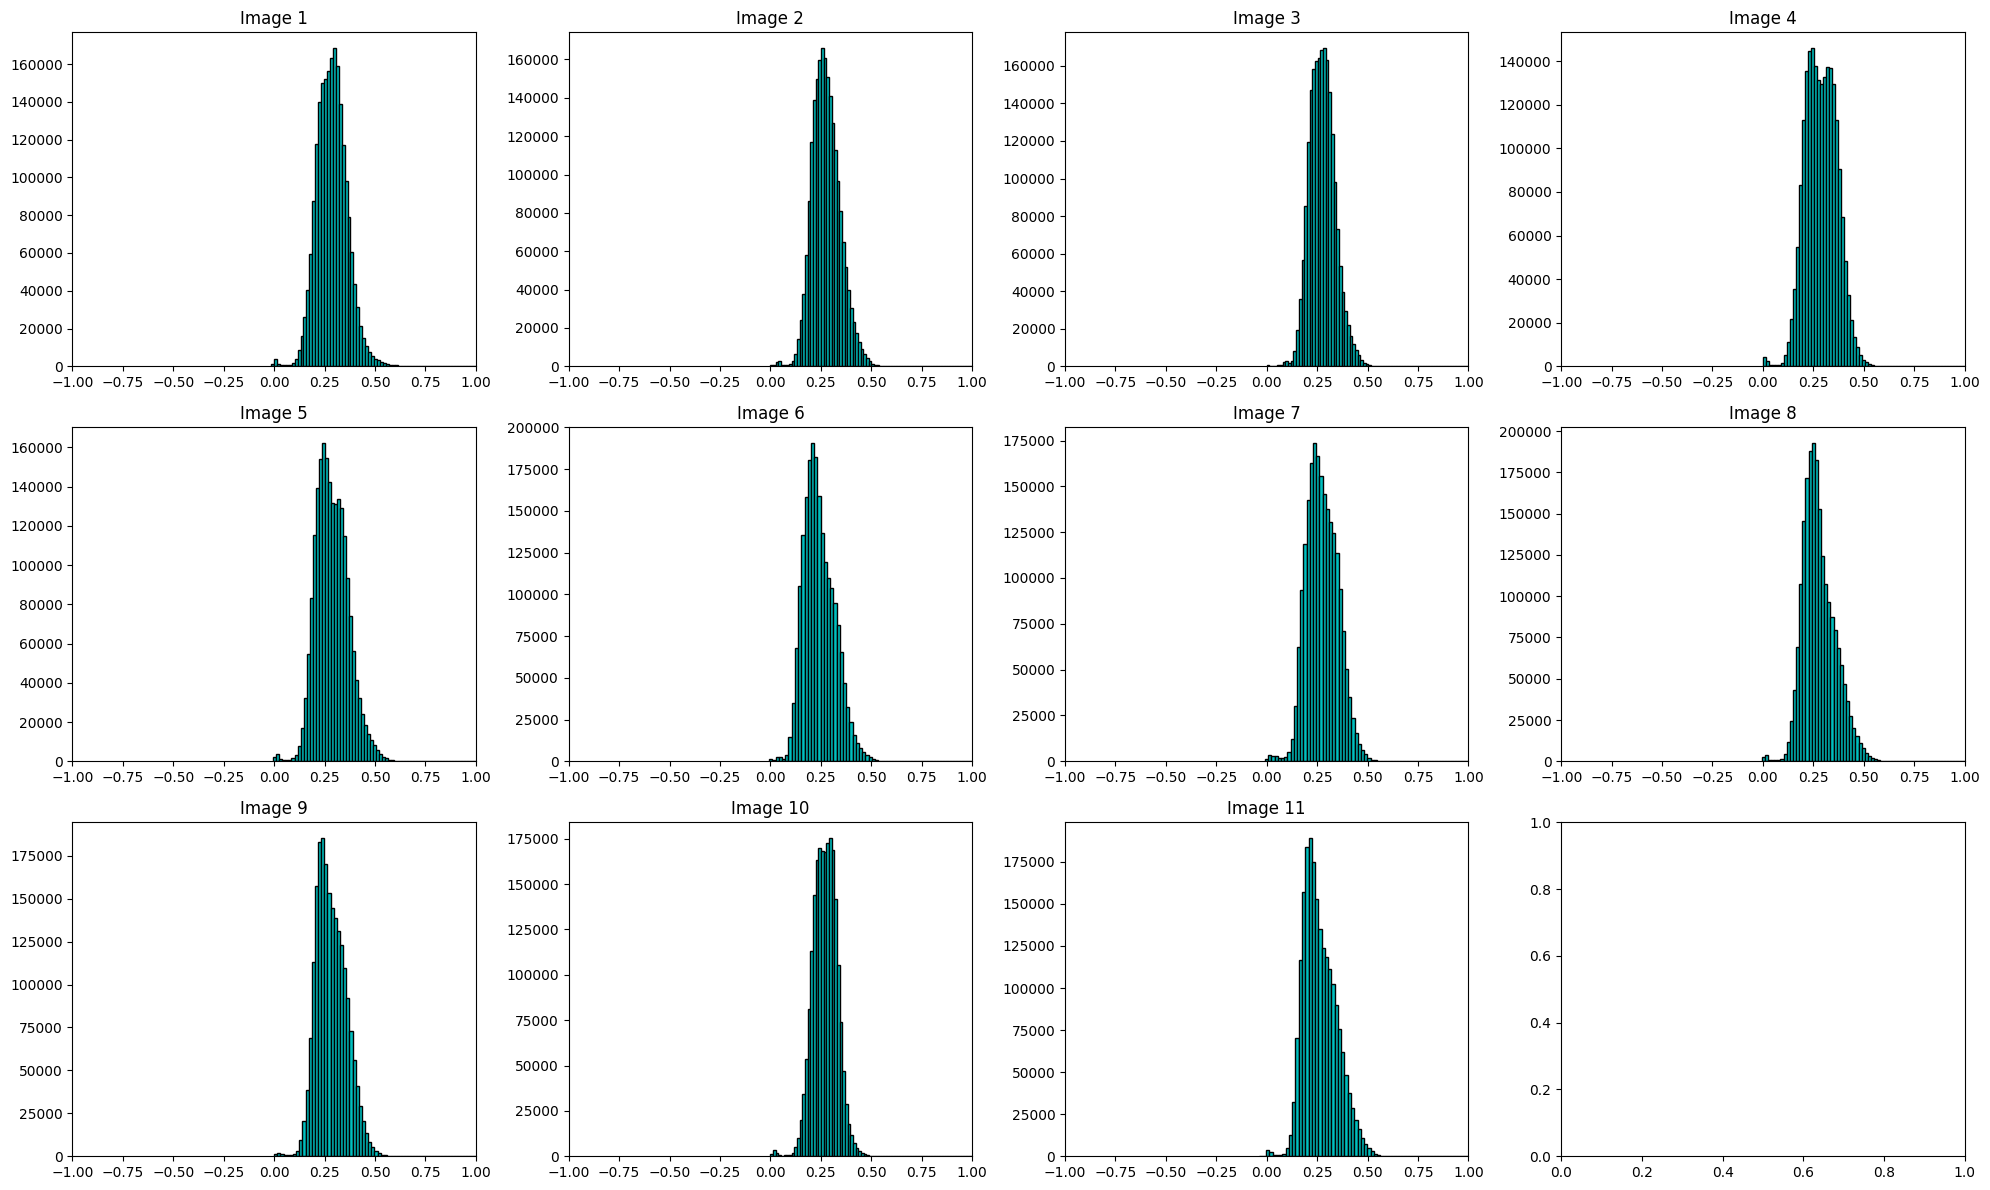

In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Assuming img_df is already defined and contains the image paths
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

# Iterate over the images and plot them in the grid
for i, img_path in enumerate(img_df[img_df['city'] == 'milan']['path']):
    # Read the image using rasterio
    with rasterio.open(img_path) as src:
        ndvi = src.read(5)
        ndvi = np.nan_to_num(ndvi)
    
    # Determine the row and column index for the subplot
    row = i // 4
    col = i % 4
    
    # Plot the image on the corresponding axis
    axes[row, col].hist(ndvi.flatten(), bins=100, color='c', edgecolor='k')
    axes[row, col].set_title(f'Image {i+1}')
    axes[row, col].set_xlim(-1, 1)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Plot NDVI

In [ ]:
import matplotlib.pyplot as plt

# Define the number of rows and columns in the grid
num_rows = 5
num_cols = 5

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Iterate over the images and plot them in the grid
for i, img_path in enumerate(img_df['path']):
    # Read the image using rasterio
    with rasterio.open(img_path) as src:
        ndvi = np.nan_to_num(src.read(6))
    
    # Plot the image on the corresponding axis
    axes[i].imshow(ndvi, cmap='gray')
    axes[i].set_title(f'NDVI {img_df['city'][i]} {img_df["year"][i]}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Cumulative Distribution Function matching

In [ ]:
def cdf_match(source, reference):
    oldshape = source.shape
    source = source.ravel()
    reference = reference.ravel()
    
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    r_values, r_counts = np.unique(reference, return_counts=True)
    
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    r_quantiles = np.cumsum(r_counts).astype(np.float64)
    r_quantiles /= r_quantiles[-1]
    
    interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)
    
    return interp_r_values[bin_idx].reshape(oldshape)

ndvi_images = []

for img_path in tqdm(img_df['path']):
    if 'milan' in img_path:
        with rasterio.open(img_path) as src:
            ndvi = np.nan_to_num(src.read(6))
            ndvi_images.append(ndvi)

# Apply CDF matching to all images
reference_image = np.mean(ndvi_images, axis=0)  # Use mean image as reference
cdf_matched_images = [cdf_match(img, ndvi_images[0]) for img in tqdm(ndvi_images)]

# Create a figure and axes for the grid
fig, axes = plt.subplots(6, 4, figsize=(20, 15))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Iterate over the images and plot them in the grid
for i, img in enumerate(cdf_matched_images):
    # Plot the image on the corresponding axis
    axes[i*2].imshow(img, cmap='gray')
    axes[i*2].set_title(f'CDF matched NDVI {img_df['city'][i]} {img_df["year"][i]}')
    axes[i*2+1].hist(img.flatten(), bins=100, color='c')
    veg = np.where(img > 0.3, 1, 0)
    axes[i*2+1].set_title(f'Vegetation {veg.mean():.2f}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Scale NDVI ?

In [ ]:
ndvi_milan = np.array([])
ndvi_naples = np.array([])

for img_path in tqdm(img_df['path']):
    with rasterio.open(img_path) as src:
        ndvi = src.read(6).flatten()
        ndvi = np.nan_to_num(ndvi)
        if 'milan' in img_path:
            ndvi_milan = np.append(ndvi_milan, ndvi)
        elif 'naples' in img_path:
            ndvi_naples = np.append(ndvi_naples, ndvi)

ndvi_milan = ndvi_milan.reshape(-1, 1)
ndvi_naples = ndvi_naples.reshape(-1, 1)
print(f'Shape of NDVI Milan: {ndvi_milan.shape} - Shape of NDVI Naples: {ndvi_naples.shape}')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler_milan = StandardScaler()
scaler_naples = StandardScaler()

# Fit the scaler with the NDVI data
scaler_milan.fit(ndvi_milan)
scaler_naples.fit(ndvi_naples)

In [ ]:
import matplotlib.pyplot as plt

# Define the number of rows and columns in the grid
num_rows = 5
num_cols = 5

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten the axes array to iterate over it
axes = axes.flatten()

milan_q = -np.inf
naples_q = -np.inf
# Iterate over the images and plot them in the grid
for i, img_path in enumerate(img_df['path']):
    # Read the image using rasterio
    with rasterio.open(img_path) as src:
        ndvi = np.nan_to_num(src.read(6)).flatten()
        if img_df['city'][i] == 'milan':
            ndvi = scaler_milan.transform(ndvi.reshape(-1, 1))
            if img_df['year'][i] == 2013:
                milan_q = np.quantile(ndvi, 0.75)
        elif img_df['city'][i] == 'naples':
            ndvi = scaler_naples.transform(ndvi.reshape(-1, 1))
            if img_df['year'][i] == 2013:
                naples_q = np.quantile(ndvi, 0.75)
    
    # Plot the image on the corresponding axis
    axes[i].hist(ndvi, label='NDVI', bins=100, color='green')
    if img_df['city'][i] == 'milan':
        axes[i].axvline(milan_q, color='red', linestyle='dashed', linewidth=1)
        axes[i].set_title(f'Milan {np.sum(ndvi > milan_q) / ndvi.size * 100:.2f}%')
    elif img_df['city'][i] == 'naples':
        axes[i].axvline(naples_q, color='red', linestyle='dashed', linewidth=1)
        axes[i].set_title(f'Naples {np.sum(ndvi > naples_q) / ndvi.size * 100:.2f}%')
    axes[i].set_xlim(-1, 1)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Define the number of rows and columns in the grid
num_rows = 5
num_cols = 5

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten the axes array to iterate over it
axes = axes.flatten()

milan_q = -np.inf
naples_q = -np.inf
# Iterate over the images and plot them in the grid
for i, img_path in enumerate(img_df['path']):
    # Read the image using rasterio
    with rasterio.open(img_path) as src:
        ndvi = src.read(6)
        ndvi = np.nan_to_num(ndvi).flatten()
        if img_df['city'][i] == 'milan':
            if img_df['year'][i] == 2013:
                milan_q = np.quantile(ndvi, 0.5)
        elif img_df['city'][i] == 'naples':
            if img_df['year'][i] == 2013:
                naples_q = np.quantile(ndvi, 0.5)
    
    # Plot the image on the corresponding axis
    axes[i].hist(ndvi, label='NDVI', bins=100, color='green')
    if img_df['city'][i] == 'milan':
        axes[i].axvline(milan_q, color='red', linestyle='dashed', linewidth=1)
        axes[i].set_title(f'Milan {np.sum(ndvi > milan_q) / ndvi.size * 100:.2f}%')
    elif img_df['city'][i] == 'naples':
        axes[i].axvline(naples_q, color='red', linestyle='dashed', linewidth=1)
        axes[i].set_title(f'Naples {np.sum(ndvi > naples_q) / ndvi.size * 100:.2f}%')
    axes[i].set_xlim(-1, 1)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Function to compute observed range of NDVI values
def compute_observed_ndvi_range(landsat_path):
    ndvi_min = np.inf
    ndvi_max = -np.inf
    
    for img in os.listdir(landsat_path):
        with rasterio.open(os.path.join(landsat_path, img)) as src:
            ndvi = src.read(6)
            
            current_min = np.nanmin(ndvi)
            current_max = np.nanmax(ndvi)
            
            if current_min < ndvi_min:
                ndvi_min = current_min
            if current_max > ndvi_max:
                ndvi_max = current_max
    
    return ndvi_min, ndvi_max

# Define a function to normalize NDVI values based on observed range and scale to -10000 to 10000
def normalize_ndvi(ndvi_img, ndvi_min, ndvi_max):
    # Normalize to range [0, 1] based on observed min and max
    ndvi_normalized = (ndvi_img - ndvi_min) / (ndvi_max - ndvi_min)
    # Scale to -10000 to 10000
    ndvi_scaled = ndvi_normalized * 20000 - 10000
    return ndvi_scaled

# Define a function to classify NDVI values
def compute_percentages_by_threshold(ndvi_img, thresholds):
    # ndvi_img is a numpy.ndarray and thresholds is a dictionary
    # with keys as labels and values as a tuple of (lower_bound, upper_bound)
    percentages = {}
    for key, value in thresholds.items():
        # Create a boolean mask where values within the threshold are True
        mask = (ndvi_img > value[0]) & (ndvi_img <= value[1])
        # Compute the percentage of True values in the mask
        percentage = np.mean(mask) * 100  # Convert fraction to percentage
        percentages[key] = percentage
    
    return percentages

In [ ]:
# Define the NDVI thresholds
ndvi_thresholds = {
    'water': (-1, 0.03),
    'roads_or_urban_areas': (0.03, 0.25),
    'vegetation': (0.25, 1)
}

landsat_path = 'images/landsat_8'
# Compute observed range of NDVI values across all images
ndvi_min, ndvi_max = compute_observed_ndvi_range(landsat_path)

In [ ]:
milan_ndvi = []
naples_ndvi = []
for img in tqdm(img_df['path']):
    with rasterio.open(img) as src:
        ndvi = src.read(6)
        if 'milan' in img:
            milan_ndvi.extend(ndvi.flatten())
        elif 'naples' in img:
            naples_ndvi.extend(ndvi.flatten())

In [ ]:
'''
    DO NOT RUN ANYMORE!!!!!!!!!

'''
# def compute_and_add_ndvi(landsat_path, city, binsize=10, epsilon=1e-9):
#     ndvi_values = []
#     for img in tqdm(os.listdir(landsat_path)):
#         if city in img:
#             input_img_path = os.path.join(landsat_path, img)
#             with rasterio.open(input_img_path, 'r+') as src:
#                 print(f'bands {src.descriptions}')
                
#                 # Store original band names
#                 original_descriptions = src.descriptions
                
#                 red = src.read(4) * 2.75e-5 - 0.2
#                 nir = src.read(5) * 2.75e-5 - 0.2
                
#                 # Adjusted NDVI calculation
#                 ndvi = (nir - red) / (nir + red + 2*0.2 + epsilon)  # Add 2*0.2 to denominator to account for offset
#                 ndvi_values.extend(ndvi.flatten())

#                 # Update metadata to include NDVI band
#                 meta = src.meta.copy()  # Create a copy of the metadata
#                 meta.update(count=src.count + 1, dtype='float32')

#                 # Write data to a new file to avoid issues with updating existing file
#                 output_img_path = input_img_path.replace('.tif', '_with_ndvi.tif')

#                 with rasterio.open(output_img_path, 'w', **meta) as dst:
#                     # Write original bands
#                     for i in range(src.count):
#                         dst.write(src.read(i + 1), i + 1)
#                         dst.set_band_description(i + 1, original_descriptions[i])
                    
#                     # Write NDVI band
#                     dst.write(ndvi.astype(rasterio.float32), src.count + 1)
#                     dst.set_band_description(src.count + 1, 'NDVI_normalized')

#                 # Replace the original file with the new file
#                 os.replace(output_img_path, input_img_path)

#     return ndvi_values

# # Define paths and city
# landsat_path = 'images/landsat_8'
# city = 'naples'

# # Compute and add NDVI values
# ndvi_values = compute_and_add_ndvi(landsat_path, city)

# # Verify the changes
# for img in os.listdir(landsat_path):
#     if city in img:
#         with rasterio.open(os.path.join(landsat_path, img)) as src:
#             print(f"Image: {img}")
#             print(f"Bands: {src.descriptions}")
#             print(f"Number of bands: {src.count}")
#             print("---")

In [ ]:
from sklearn.cluster import KMeans

# Function to compute NDVI frequencies
def compute_ndvi_frequencies(landsat_path, city, binsize=10, epsilon=1e-9):
    ndvi_values = []
    for img in tqdm(os.listdir(landsat_path)):
        if city in img:
            with rasterio.open(os.path.join(landsat_path, img)) as src:
                ndvi = src.read(7)
                ndvi_values.extend(ndvi.flatten())
                
    return ndvi_values

binsize = 10
# Compute NDVI frequencies for Milan images
ndvi_milan = compute_ndvi_frequencies(landsat_path='images/landsat_8', city='milan', binsize=binsize)
ndvi_naples = compute_ndvi_frequencies(landsat_path='images/landsat_8', city='naples', binsize=binsize)

In [ ]:
plt.hist(ndvi_milan, bins=100, color='blue', alpha=0.5, label='Milan')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.title('NDVI Frequency Distribution')
plt.show()

In [ ]:
plt.hist(ndvi_naples, bins=100, color='blue', alpha=0.5, label='Naples')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.title('NDVI Frequency Distribution')
plt.show()

In [ ]:
# Reshape histogram for clustering
ndvi_milan = np.array(ndvi_milan).reshape(-1, 1)
ndvi_naples = np.array(ndvi_naples).reshape(-1, 1)

# Apply K-means clustering
kmeans_milan = KMeans(n_clusters=3, random_state=69420)
kmeans_milan.fit(ndvi_milan)
print('K means performed for Milan')

kmeans_naples = KMeans(n_clusters=3, random_state=69420)
kmeans_naples.fit(ndvi_naples)
print('K means performed for Naples')

# Retrieve cluster centroids (potential thresholds)
thresholds_milan = kmeans_milan.cluster_centers_.flatten()
thresholds_naples = kmeans_naples.cluster_centers_.flatten()

In [ ]:
# Plot histogram and centroids
plt.figure(figsize=(10, 6))
plt.hist(ndvi_milan, bins=100, alpha=0.7, label='NDVI Histogram')
plt.axvline(x=thresholds_milan[0], color='r', linestyle='--', label='Threshold 1')
plt.axvline(x=thresholds_milan[1], color='g', linestyle='--', label='Threshold 2')
plt.axvline(x=thresholds_milan[2], color='b', linestyle='--', label='Threshold 3')
plt.xlabel('NDVI Values')
plt.ylabel('Frequency')
plt.title('Milan - NDVI Frequency Distribution with K-means Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Print identified thresholds
print("Identified thresholds:", thresholds_milan)

# Plot histogram and centroids
plt.figure(figsize=(10, 6))
plt.hist(ndvi_naples, bins=100, alpha=0.7, label='NDVI Histogram')
plt.axvline(x=thresholds_naples[0], color='r', linestyle='--', label='Threshold 1')
plt.axvline(x=thresholds_naples[1], color='g', linestyle='--', label='Threshold 2')
plt.axvline(x=thresholds_naples[2], color='b', linestyle='--', label='Threshold 3')
plt.xlabel('NDVI Values')
plt.ylabel('Frequency')
plt.title('Naples - NDVI Frequency Distribution with K-means Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Print identified thresholds
print("Identified thresholds:", thresholds_naples)

In [ ]:
import numpy as np
import rasterio

def moving_average_ndvi(landsat_path, city):
    # Carica i tuoi dati NDVI in un array 3D
    ndvi_3d = []
    for img in tqdm(os.listdir(landsat_path)):
        if city in img:
            with rasterio.open(os.path.join(landsat_path, img)) as src:
                ndvi_3d.append(src.read(7))
    return ndvi_3d

ndvi_3d = moving_average_ndvi(landsat_path='images/landsat_8', city='naples')

ndvi_3d = np.array(ndvi_3d)

# Applica la media mobile lungo l'asse temporale
smoothed_ndvi_3d = np.apply_along_axis(
    lambda x: pd.Series(x).rolling(window=3, center=True).mean().values,
    axis=0,
    arr=ndvi_3d
)

# Ora smoothed_ndvi_3d contiene i dati NDVI smoothed per ogni pixel

In [ ]:
from sklearn.cluster import KMeans

def kmeans_thresholds(smoothed_ndvi, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(smoothed_ndvi.reshape(-1, 1))
    thresholds = np.sort(kmeans.cluster_centers_.flatten())
    return thresholds

print(smoothed_ndvi_3d.shape)
# Esempio di utilizzo
thresholds = kmeans_thresholds(smoothed_ndvi_3d.flatten())
print(f"K-means thresholds: {thresholds}")

In [ ]:
np.isnan(np.nan_to_num(smoothed_ndvi_3d, copy=False)).sum()
np.isnan(smoothed_ndvi_3d).sum()

In [ ]:
print(thresh_vegetation)

In [ ]:
def get_quantiles(ndvi):
    quantiles = []
    for i in range(1, 20):
        q = np.quantile(ndvi, i/20)
        quantiles.append(q)
    return quantiles

def plot_quantiles_for_year(landsat_path, city):
    for img in os.listdir(landsat_path):
        if city in img:
            with rasterio.open(os.path.join(landsat_path, img)) as src:
                
                ndvi = src.read(6)
                red = src.read(4)
                green = src.read(3)
                blue = src.read(2)

                red = np.nan_to_num(red)
                green = np.nan_to_num(green)
                blue = np.nan_to_num(blue)
                ndvi = np.nan_to_num(ndvi)

                img = np.stack([red, green, blue], axis=-1)
                quantiles = get_quantiles(ndvi.flatten())

                fig, axes = plt.subplots(1, 2, figsize=(10, 4))
                mask = ndvi
                if 'milan' in img:
                    mask = ndvi > quantiles[9]
                elif 'naples' in img:
                    mask = ndvi # > quantiles[9]
                axes[0].imshow(mask, cmap='viridis')
                axes[1].hist(ndvi.flatten(), color='r', bins=100, alpha=0.5, label='NDVI')

                for i, q in enumerate(quantiles):
                    plt.axvline(q, color='k' if i ==12 else 'r' if i%3==1 else 'b' if i%3==2 else 'g', linestyle='--', label=f'{(i+1)*5} Quantile')
                    
                plt.title(f'{i} Image and NDVI')
                plt.tight_layout()
                plt.legend()
                plt.show()

landsat_path = 'images/landsat_8_10_clouds'
# plot_quantiles_for_year(landsat_path=landsat_path, city='milan')
# plot_quantiles_for_year(landsat_path=landsat_path, city='naples')

def get_quantiles_first_year(landsat_path, city, year=2013):
    for img in os.listdir(landsat_path):
        if city in img and str(year) in img:
            with rasterio.open(os.path.join(landsat_path, img)) as src:
                ndvi = np.nan_to_num(src.read(6))
                quantiles = get_quantiles(ndvi.flatten())
                print(quantiles)
                plt.hist(ndvi.flatten(), bins=100, alpha=0.5, label='NDVI')
                for i, q in enumerate(quantiles):
                    plt.axvline(q, color='k' if i ==12 else 'r' if i%3==1 else 'b' if i%3==2 else 'g', linestyle='--', label=f'{(i+1)*5} Quantile')
                plt.title(f'{img} Image and NDVI')
                plt.tight_layout()
                plt.legend()
                plt.show()
                if city == 'naples':
                    return quantiles[12]
                elif city == 'milan':
                    return quantiles[12]

thresh_vegetation = get_quantiles_first_year(landsat_path=landsat_path, city='milan', year=2013)

ndvi_thresholds = {
    'water': (-1, -1),
    'roads_or_urban_areas': (-1, thresh_vegetation),
    'vegetation': (thresh_vegetation, 1)
}

# Define a function to classify NDVI values
def compute_percentages_by_threshold(ndvi_img, thresholds):
    # ndvi_img is a numpy.ndarray and thresholds is a dictionary
    # with keys as labels and values as a tuple of (lower_bound, upper_bound)
    percentages = {}
    for key, value in thresholds.items():
        # Create a boolean mask where values within the threshold are True
        mask = (ndvi_img > value[0]) & (ndvi_img <= value[1])
        # Compute the percentage of True values in the mask
        percentage = np.mean(mask) * 100  # Convert fraction to percentage
        percentages[key] = percentage
    
    return percentages

for img in tqdm(img_df['path']):
    with rasterio.open(img) as src:
        ndvi = src.read(6)
        img_name = img.split('/')[-1]
        percentages = compute_percentages_by_threshold(ndvi, ndvi_thresholds)
        img_df.loc[img_df['path'] == img, 'water'] = percentages['water']
        img_df.loc[img_df['path'] == img, 'roads_or_urban_areas'] = percentages['roads_or_urban_areas']
        img_df.loc[img_df['path'] == img, 'vegetation'] = percentages['vegetation']

img_df